# How to Implement Learning to Rank Model using Python
### The step-by-step guide on how to implement the lambdarank algorithm using Python and LightGBM

In this article, we will build a lambdarank algorithm for anime recommendations. A research group first introduced LambdaRank at Microsoft, and now it's available on Microsoft's LightGBM library with an easy-to-use sklearn wrapper. Let's start.

__From Search Engines to Product Recommendations__
As mentioned above, ranking is widely used in search engines. But it's not limited to search engines; we can adopt the concept and build a solution whenever applicable. Assuming that we want to develop a ranking model for a search engine, we should start with a dataset with queries, its associated documents(URLs), and the relevance score for each query document pair, as shown below.

![images/1.jpg](images/1.jpg)

Finally, we can derive features based on each query and document pair.

![images/2.jpg](images/2.jpg)

This is the dataset format for well-known Learning to Rank research papers and datasets. Well, that's about search engines. Let's discuss how we can adapt these concepts for traditional product recommendation tasks. There are various ways to recommend products to users. You can show recommendations when the user perches an item, or while a user is browsing the page, etc. But for simplicity, let's narrow it down to a specific scenario.

This article will build an anime recommendation model for users' homepage customization. When the user logs into the account, we need to show animes based on the relevance scores predicted by the ranker model. Here I will use Anime Recommendation LTR Dataset, which is available under a public license. You can access it via [this kaggle](https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset) link.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing,model_selection,metrics
from lightgbm import LGBMRanker

warnings.filterwarnings('ignore')

In [3]:
from tabulate import tabulate
from functools import wraps

def print_tabulate(df):
        if isinstance(df, pd.DataFrame):
            print(tabulate(df, headers='keys', tablefmt='psql'))
        else:
            return df

In [4]:
!kaggle datasets download -d ransakaravihara/anime-recommendation-ltr-dataset

anime-recommendation-ltr-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
zipped_data = zipfile.ZipFile("anime-recommendation-ltr-dataset.zip")

In [6]:
zipped_data.namelist()

['anime_info.csv', 'relavence_scores.csv', 'user_info.csv']

Let's read the dataset and quickly check its columns.

In [7]:
anime_info_df = pd.read_csv(zipped_data.open('anime_info.csv'))
relavence_scores = pd.read_csv(zipped_data.open('relavence_scores.csv'))
user_info = pd.read_csv(zipped_data.open('user_info.csv'))

In [8]:
relavence_scores = relavence_scores[~(relavence_scores['user_id']==11100)]

In [9]:
anime_info_df.head()

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013


Alright, let me explain the methodology I am going to use here. Unlike search engine data, we don't have query and document pairs in this use case. So we will treat users as queries and the animes they are interested in as documents. One search query can be associated with multiple documents; users can interact with many animes. You got the idea, right :)

The target label we predict here is relevance_score, stored in the relevance_scores dataset. When we build a raking model, it will learn a function to rank those anime into an optimum order where the highest relevant anime comes first for each user.

Next, we need to create a dataset by joining the above three datasets. I will also create new features based on anime and user features. Let's create a dataset.

In [13]:
popular_genres = ['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Kids',
 'Drama',
 'Sci-Fi',
 'Music',
 'Shounen',
 'Slice of Life']

In [14]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def create_genre_flags(df, popular_genres):
    df = df.dropna(subset=['Genres'])
    df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))
    # use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
    mlb = MultiLabelBinarizer()
    genre_df = pd.DataFrame(mlb.fit_transform(df['Genres'].str.split(',')),
                            columns=mlb.classes_,
                            index=df.index)
    # create a new dataframe with the movie id and genre columns
    new_df = pd.concat([df['anime_id'], genre_df[popular_genres]], axis=1)
    new_df.columns = ['anime_id'] + popular_genres
    return new_df

In [15]:
anime_genre_info_df = create_genre_flags(anime_info_df,popular_genres)

In [16]:
anime_info_df_final = anime_info_df.merge(anime_genre_info_df,on='anime_id')

In [17]:
del anime_info_df_final['Genres']

In [18]:
anime_info_df_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_df_final.columns]

In [19]:
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]

In [21]:
def create_histogram(data, xname, n_bins=100, background_color='#F3F3F3', title=None):
    
    import matplotlib as mpl
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'sans-serif'
    # mpl.rcParams['font.weight'] = 'semibold'

    plt.figure(figsize=(10,8))
    plt.hist(data, bins=n_bins, color='#2596be', edgecolor='black')
    plt.xlabel(xname)
    plt.ylabel('Frequency')
    ax = plt.gca()
    ax.set_facecolor(background_color)
    plt.grid(True, which='both', color='lightgray', linewidth=0.5)
    plt.title(title.upper(),fontweight='semibold',fontfamily='sans-serif')
    plt.show()

Let's quickly check a few statistics of our dataset. In total, there are 4.8Mn user-anime interactions, 15K users, and 16K animes in the dataset.

Here is the user and anime interaction distribution.

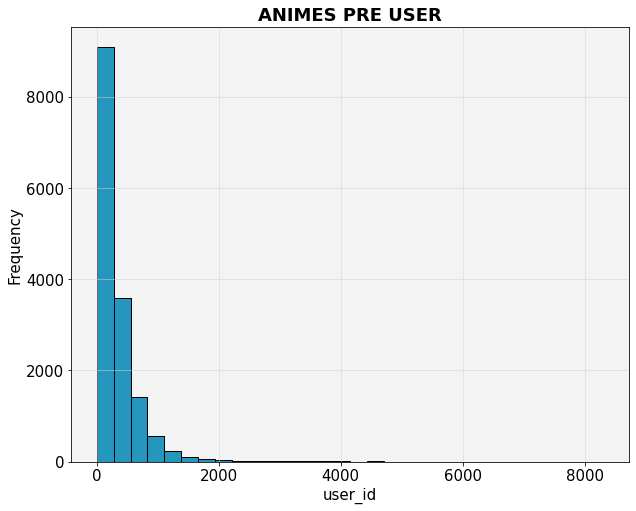

In [22]:
create_histogram(relavence_scores.groupby("user_id")['user_id'].agg('count'),xname='user_id', n_bins=30, title='Animes pre user')

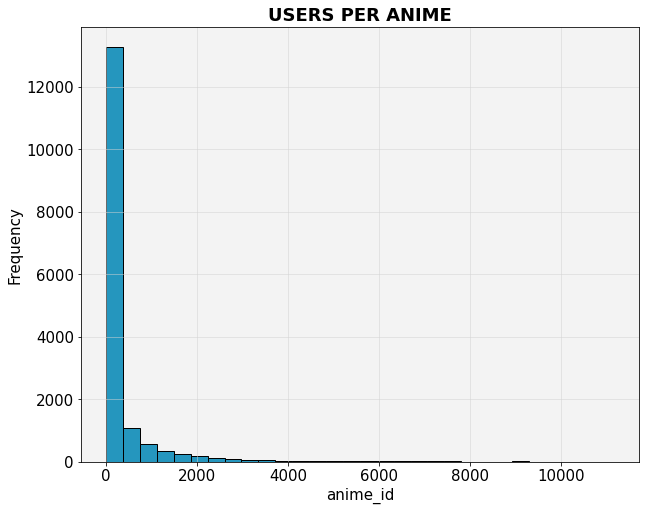

In [23]:
create_histogram(relavence_scores.groupby("anime_id")['anime_id'].agg('count'),xname='anime_id', n_bins=30, title='Users per anime')

In [24]:
f"""there are {relavence_scores['user_id'].nunique():,.0f} unique users and {relavence_scores['anime_id'].nunique():,.0f} unique animes and {len(relavence_scores):,.0f} user-anime interactions"""

'there are 15,162 unique users and 16,109 unique animes and 4,864,759 user-anime interactions'

The below chart shows how the relevance score is distributed.

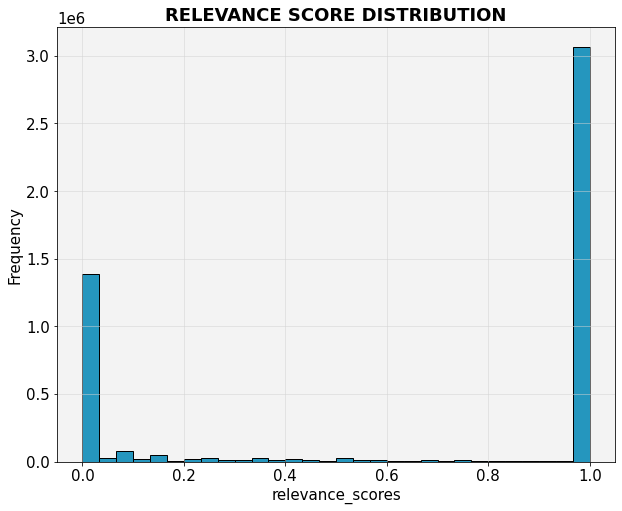

In [25]:
create_histogram(relavence_scores['relavence_score'],xname='relevance_scores', n_bins=30, title='Relevance Score Distribution')

Now we have created the dataset for model training. But one of the main confusing points of the Learning to Rank model is the group parameter. Because the group is a strange parameter for us since it is not used in other machine-learning algorithms. The idea of group parameter is partitioning the dataset for each query and document pair. It enables the model to learn the relative importance of different features within each group, which can improve the model's overall performance. Having ten user-anime pairs means we have ten groups in our LTR model. Each group can be different in size. But the summation groups should be the number of samples we have. In simple words, we have an input model to group boundaries using group parameters. Then the model can identify each user-anime instance separately.

For example, if you have a 6-anime dataset with group = [3, 2, 1], which means that you have three groups, where the first three records are in the first group, records 4–5 are in the second group, and record 6 is in the third group.

![images/3.jpg](images/3.jpg)

__So it's vital to sort the dataset by user_id before creating the group parameter.__

In [26]:
train_interim = relavence_scores.merge(anime_info_df_final)
train = train_interim.merge(user_info,how='inner')

In [27]:
na_counts = (train.isna().sum() * 100/len(train))

In [28]:
train_processed = train.drop(na_counts[na_counts > 50].index,axis=1)

In [29]:
train_processed.sort_values(by='user_id',inplace=True)

In [30]:
train_processed.columns

Index(['anime_id', 'Name', 'user_id', 'relavence_score', 'ANIME_FEATURE IS_TV',
       'ANIME_FEATURE YEAR_AIRED', 'ANIME_FEATURE IS_ADULT',
       'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE', 'USER_FEATURE REVIEW_COUNT',
       'USER_FEATURE AVG_SCORE', 'USER_FEATURE SCORE_STDDEV',
       'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [31]:
train_processed.set_index("user_id",inplace=True)

In [32]:
features = ['ANIME_FEATURE IS_TV',
       'ANIME_FEATURE YEAR_AIRED', 'ANIME_FEATURE IS_ADULT',
       'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE', 'USER_FEATURE REVIEW_COUNT',
       'USER_FEATURE AVG_SCORE', 'USER_FEATURE SCORE_STDDEV',
       'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO']

In [33]:
target = 'relavence_score'

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score,coverage_error

In [35]:
test_size = int(1e5)
X,y = train_processed[features],train_processed[target].apply(lambda x:int(x*10))
test_idx_start = len(X)-test_size

xtrain,xtest,ytrain,ytest = X.iloc[0:test_idx_start],X.iloc[test_idx_start:],y.iloc[0:test_idx_start],y.iloc[test_idx_start:]

In [36]:
get_group_size = lambda df: df.reset_index().groupby("user_id")['user_id'].count()

In [37]:
train_groups = get_group_size(xtrain)
test_groups = get_group_size(xtest)

In [38]:
sum(train_groups) , sum(test_groups)

(4764372, 100000)

In the above code snippet, I have done the following steps,

1. Dropped all the columns which have more than 50% null values.
2. Sorted dataset based on user_id. Otherwise, a group parameter will have inconsistent groups everywhere.
4. After sorting the dataset, I declared the last 100,000 rows as validation data and the rest as training data.
4. Since the LightGBM model expects integers as target values, I have scaled the target between 1–10 and converted it to an integer. ( If you want, try converting it to 0 or 1 based on the threshold).
5. Defined the groups parameter for train and tes data

In [39]:
model = LGBMRanker(objective="lambdarank",n_estimators=20)
model.fit(xtrain,ytrain,group=train_groups,eval_set=[(xtest,ytest)],eval_group=[test_groups],eval_metric=['map'])

[1]	valid_0's map@1: 0.863354	valid_0's map@2: 0.84705	valid_0's map@3: 0.825397	valid_0's map@4: 0.816447	valid_0's map@5: 0.809951	valid_0's ndcg@1: 0.854927	valid_0's ndcg@2: 0.857799	valid_0's ndcg@3: 0.849489	valid_0's ndcg@4: 0.845283	valid_0's ndcg@5: 0.844731
[2]	valid_0's map@1: 0.875776	valid_0's map@2: 0.863354	valid_0's map@3: 0.8505	valid_0's map@4: 0.832665	valid_0's map@5: 0.829016	valid_0's ndcg@1: 0.860415	valid_0's ndcg@2: 0.870321	valid_0's ndcg@3: 0.867802	valid_0's ndcg@4: 0.857057	valid_0's ndcg@5: 0.857424
[3]	valid_0's map@1: 0.881988	valid_0's map@2: 0.865683	valid_0's map@3: 0.848948	valid_0's map@4: 0.833053	valid_0's map@5: 0.823736	valid_0's ndcg@1: 0.866627	valid_0's ndcg@2: 0.87533	valid_0's ndcg@3: 0.867993	valid_0's ndcg@4: 0.859304	valid_0's ndcg@5: 0.854882
[4]	valid_0's map@1: 0.872671	valid_0's map@2: 0.863354	valid_0's map@3: 0.844979	valid_0's map@4: 0.835706	valid_0's map@5: 0.830455	valid_0's ndcg@1: 0.857352	valid_0's ndcg@2: 0.867246	valid_0's

LGBMRanker(n_estimators=20, objective='lambdarank')

lright, now we finished the training. It's time to make some predictions about specific customers.

There is one more critical point to notice here. That is, how the model predictions are calculated. I was confused because when calling the `.predict` method, it does not expect additional parameters such as group. So I found below information from GitHub issues. According to the creator of LightGBM mentioned in [this issue](https://github.com/microsoft/LightGBM/issues/3326), LightGBM's lambdarank uses a pointwise approach to generate predictions. Meaning we do not want to provide additional parameters such as group. We can call the `.predict()` method with the correct feature vector.

However, since we are developing the LTR model, it's essential to have some candidate products and rank those according to the predicted relevance score. To generate candidate animes, I will use a straightforward method here. That is, select the animes that are not exposed to a given user. Select an N random subset from unexposed animes. Generate features based on user and selected N anime subset. Finally, use generated feature vector to get the relevance score and sort animes based on the relevance score. But in real-world use cases, we should use some meaningful methodologies. As an example, you can generate candidates as follows,

1. Select the user's favourite N number of genres.
2. For each genre in the above-selected genres, pick the highest-rated m animes. Now you have M* N animes to rank for that user. Just create the user base and anime-based features. And finally, call the `.predict()` method with the created feature vector.

In [42]:
user_2_anime_df = relavence_scores.groupby("user_id").agg({"anime_id":lambda x:list(set(x))})

In [43]:
user_2_anime_map = dict(zip(user_2_anime_df.index,user_2_anime_df['anime_id']))

In [44]:
candidate_pool = anime_info_df_final['anime_id'].unique().tolist()

In [45]:
def candidate_generation(user_id,candidate_pool,user_2_anime_map,N):
    already_interacted = user_2_anime_map[user_id]
    candidates = list(set(candidate_pool) - set(already_interacted))
    return already_interacted,np.random.choice(candidates,size=N)

In [49]:
anime_id_2_name = relavence_scores.drop_duplicates(subset=["anime_id","Name"])[['anime_id',"Name"]]
anime_id_2_name_map = dict(zip(anime_id_2_name['anime_id'],anime_id_2_name['Name']))
anime_id_2_name_map[1]

'Cowboy Bebop'

In [50]:
def generate_predictions(user_id,user_2_anime_map,candidate_pool,feature_columns,anime_id_2_name_map,ranker,N=100):
    already_liked,candidates = candidate_generation(user_id,candidate_pool,user_2_anime_map,N=10000)
    candidates_df = pd.DataFrame(data=pd.Series(candidates,name='anime_id'))
    features = anime_info_df_final.merge(candidates_df)
    features['user_id'] = user_id
    features = features.merge(user_info)
    
    already_liked = list(already_liked)
    if len(already_liked) < len(candidates):
        append_list = np.full(fill_value=-1,shape=(len(candidates)-len(already_liked)))
        already_liked.extend(list(append_list))
    
    predictions = pd.DataFrame(index=candidates)
    predictions['name'] = np.array([anime_id_2_name_map.get(id_) for id_ in candidates])
    predictions['score'] = ranker.predict(features[feature_columns])
    predictions = predictions.sort_values(by='score',ascending=False).head(N)
    
    predictions[f'already_liked - sample[{N}]'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]
    return predictions

In [51]:
print_tabulate(generate_predictions(123,user_2_anime_map,candidate_pool,feature_columns=features,anime_id_2_name_map=anime_id_2_name_map,ranker=model,N=10))

+-------+------------------------------------------------------+---------+------------------------------+
|       | name                                                 |   score | already_liked - sample[10]   |
|-------+------------------------------------------------------+---------+------------------------------|
| 20267 | Wooser no Sono Higurashi: Kakusei-hen                | 2.14745 | Majo no Takkyuubin           |
|  3864 | Souten no Ken Specials                               | 2.14745 | Tenkuu no Shiro Laputa       |
|  3613 | Toshokan Sensou                                      | 2.11424 | Pumpkin Scissors             |
| 15915 | Magical Hat                                          | 2.11424 | Omoide Poroporo              |
| 31370 | Tonkatsu DJ Agetarou                                 | 2.11424 | Heisei Tanuki Gassen Ponpoko |
|  4810 | Shinzou Ningen Casshern                              | 2.10967 | Tonari no Totoro             |
| 40172 | Lucky☆Orb feat. Hatsune Miku        

In [60]:
def generate_shap_plots(ranker, X_train, feature_names, N=3):
    """
    Generates SHAP plots for a pre-trained LightGBM model.
    
    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate
    
    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])
    
    # Create a figure with 2 subplots
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # Plot the summary plot on the first subplot
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')
    
    # Plot the feature importance plot on the second subplot
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
    
    plt.show()

Additionally, we can use shap to explain the model's predictions.

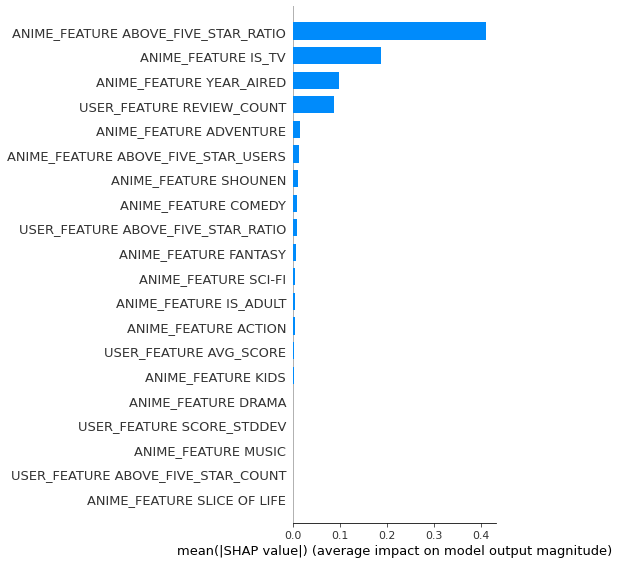

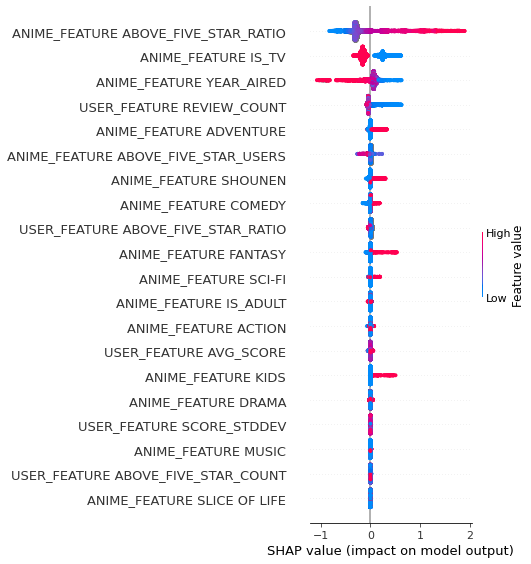

In [63]:
generate_shap_plots(model,xtrain,features,N=10000)